# Oracle Machine Learning for Python - Embedded Python Execution
Oracle Machine Learning for Python (OML4Py), a component of the Oracle Advanced Analytics option to Oracle Database Enterprise Edition, makes the open source Python scripting language and environment ready for the enterprise and big data. Designed for problems involving both large and small volumes of data, Oracle Machine Learning for Python integrates Python with Oracle Database, allowing users to execute Python commands and scripts for statistical, machine learning, and graphical analyses on database tables and views using Python syntax. Many familiar Python functions are overloaded and translate Python functions into SQL for in-database execution, as well as new automated machine learning capabilities. 
![title](img/OML4P_icon.jpg)
In this notebook, we highlight using OML4Py Embedded Python Execution. We first build a linear model in Python directly, then create a function that will be executed on the database server side. Examples of additional server-side execution are also highlighted. 

# Connect to Oracle Database
To use OML4Py, first import the package ***oml***. OML4Py supports a variety of connection specification options, including Oracle Wallet. Once connected to an Oracle Database that has OML4Py installed, invoking ***oml.isconnected*** returns true. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import oml
oml.connect(user="pyquser",password="Welcome1#Welcome1#",dsn='(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST=130.61.241.158)(PORT=1521))(CONNECT_DATA=(service_name=pdbx.sub12041412510.bdcevcn.oraclevcn.com)))')
oml.isconnected()

True

# Create a Pandas DataFrame and load into Oracle Database
In this first example, we load the _iris_ data and combine target and predictors into a single DataFrame, which matches the form the data would have as a database table. We then create the IRIS table and obtaining the OML DataFrame proxy object. 

In [2]:
from sklearn.datasets import load_iris
from sklearn import linear_model
import pandas as pd

iris = load_iris()
x = pd.DataFrame(iris.data, 
                 columns = ["SEPAL_LENGTH", "SEPAL_WIDTH", "PETAL_LENGTH", "PETAL_WIDTH"])
y = pd.DataFrame(list(map(lambda x: {0:'setosa', 1: 'versicolor', 2:'virginica'}[x], iris.target)), 
                 columns = ['Species'])
iris_df = pd.concat([x,y], axis=1)

try:
    oml.drop(table="IRIS")
except:
    pass
IRIS = oml.create(iris_df, table="IRIS")
IRIS.head(4)

   SEPAL_LENGTH  SEPAL_WIDTH  PETAL_LENGTH  PETAL_WIDTH Species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa

# Build and score a linear model from sklearn directly in Python
A best practice with embedded Python execution is to validate your Python script, and then your user-defined function before invoking the embedded Python APIs. The next few cells exercise the functionality we want. 

In [3]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
X = iris_df[["PETAL_WIDTH"]]
y = iris_df[["PETAL_LENGTH"]]
mod = lm.fit(X, y)
print("Model:",mod)

Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [4]:
pred = mod.predict(iris_df[["PETAL_WIDTH"]])
pred[0:10]

array([[1.52954613],
       [1.52954613],
       [1.52954613],
       [1.52954613],
       [1.52954613],
       [1.97553423],
       [1.75254018],
       [1.52954613],
       [1.52954613],
       [1.30655208]])

# Assess model quality using mean squared error and R^2

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

print('Coefficients: \n', mod.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(iris_df[["PETAL_LENGTH"]], pred))

print('Variance score (1 is perfect prediction): %.2f' % r2_score(iris_df[["PETAL_LENGTH"]], pred))

Coefficients: 
 [[2.2299405]]
Mean squared error: 0.23
Variance score (1 is perfect prediction): 0.93


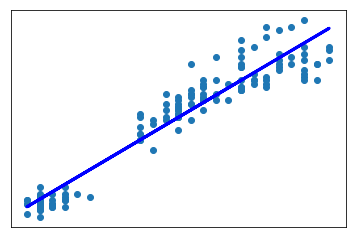

In [6]:
import matplotlib.pyplot as plt

plt.scatter(iris_df.loc[:,"PETAL_WIDTH"], iris_df.loc[:,"PETAL_LENGTH"])
plt.plot(iris_df[["PETAL_WIDTH"]], pred, color='blue', linewidth=3)

plt.xticks(()) # Disable ticks
plt.yticks(())

plt.show()

# Build this same model at the database server machine 
Using embedded Python execution, let's build the same linear model, but on the database server. First, we'll define our function, ***build_lm_1***, that returns the model as the result. We refer to this as a "user-defined function." We'll go further and score the training data and plot the model against the data points. Note that embedded Python execution can return images as well as structured content in the Python API. In the SQL API, as you'll see in another script, you choose between structured data, images, or XML output. 

We execute this function to ensure it returns what we expect. In this case, both an image and a model. 

In [7]:
def build_lm_1(dat):
    import oml
    from sklearn import linear_model
    import matplotlib.pyplot as plt

    lm = linear_model.LinearRegression()
    X = dat[["PETAL_WIDTH"]]
    y = dat[["PETAL_LENGTH"]]
    mod = lm.fit(X, y)
    
    pred = mod.predict(dat[["PETAL_WIDTH"]])
    plt.scatter(dat.loc[:,"PETAL_WIDTH"], dat.loc[:,"PETAL_LENGTH"])
    plt.plot(dat[["PETAL_WIDTH"]], pred, color='blue', linewidth=3)
    plt.xticks(()) # Disable ticks
    plt.yticks(())
    plt.show()
    return mod

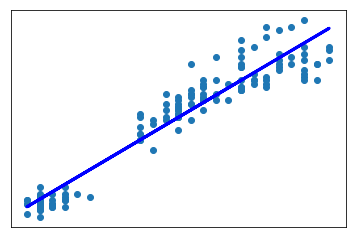

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [8]:
build_lm_1(iris_df)

The ***table_apply*** function takes the proxy object IRIS as input data and loads that data to the user-defined function as a pandas DataFrame. The user-defined function is passed as a Python function object. We see that the model comes back as an OML object, which we can pull to the client and see that it's the linear model. We also display the image automatically. 

Type: <class 'oml.embed.object.Object'>
Object: 

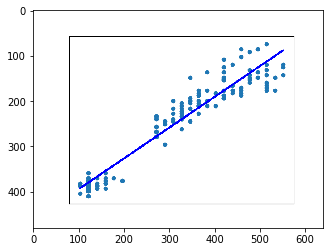

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Type: <class 'sklearn.linear_model.base.LinearRegression'>
Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficient [[2.2299405]]


In [9]:
mod = oml.table_apply(data=IRIS, func = build_lm_1)
print("Type:",type(mod))
print("Object:",mod)

mod_local = mod.pull()
print("\nType:",type(mod_local))
print("Model:",mod_local)
print("Coefficient", mod_local.coef_)

We can also save user-defined function in the Python script repository and invoke the same table applying function by providing the function name string.

In [10]:
oml.script.create("build_lm_1", build_lm_1, overwrite = True)
oml.script.dir()

,name,script
0,build_lm_1,def build_lm_1(dat):\n import oml\n from...
1,pyqFun1,def pyqFun1 ():\n import numpy as np\n i...
2,pyqFun2,"func = lambda: ""Hello World from a lambda!"""
3,showenvironment,def return_vars():\n import os\n print(os....
4,sk_svc_fit,def fit(data):\n import matplotlib.pyplot a...
5,testfun,"def return_hello():\n return ""Hello man"""


Notice the value to "func". The results are the same. 

Type: <class 'oml.embed.object.Object'>
Object: 

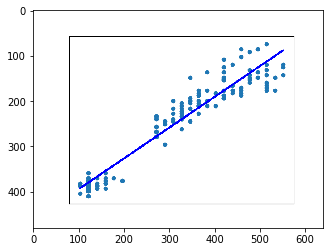

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Type: <class 'sklearn.linear_model.base.LinearRegression'>
Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Coefficient [[2.2299405]]


In [11]:
mod = oml.table_apply(data=IRIS, func = 'build_lm_1')

print("Type:",type(mod))
print("Object:",mod)

mod_local = mod.pull()
print("\nType:",type(mod_local))
print("Model:",mod_local)
print("Coefficient", mod_local.coef_)

The ***row_apply*** function can be used to invoke a user-defined function on chunks of rows, which is useful to perform scoring in parallel for native Python models. In this example, the user-defined function ***score_lm_1*** takes a pandas DataFrame and a linear model. The ***row_apply*** invocation takes as arguments the proxy object IRIS, that we want 10 rows scored at a time (resulting in 15 function invocations), the user-defined functions, the linear model object, that we want to have 5 parallel Python engines to process the 15 invocations, and that we want the result to be returned as a single table. 

For illustrative purposes, you can also use the ***group_apply*** function to partition the data according to one or more columns and score as well, passing the model as an argument. 

In [12]:
def score_lm_1(dat, model):
    import pandas as pd
    from sklearn import linear_model
    pred = model.predict(dat[["PETAL_WIDTH"]])
    return pd.concat([dat[['Species', 'PETAL_LENGTH']], 
                      pd.DataFrame(pred, columns=['PRED_PETAL_LENGTH'])], axis=1)

res = oml.row_apply(IRIS, rows=10, func=score_lm_1, model=mod_local, parallel=2,
                    func_value=pd.DataFrame([('a', 1, 1)], 
                                            columns=['Species', 'PETAL_LENGTH', 'PRED_PETAL_LENGTH']))
res.head()

  Species  PETAL_LENGTH  PRED_PETAL_LENGTH
0  setosa           1.4           1.529546
1  setosa           1.4           1.529546
2  setosa           1.3           1.529546
3  setosa           1.5           1.529546
4  setosa           1.4           1.529546

In [13]:
res = oml.group_apply(IRIS, index=IRIS[['Species']], func=score_lm_1, model=mod_local, parallel=2,
                    func_value=pd.DataFrame([('a', 1, 1)], 
                                            columns=['Species', 'PETAL_LENGTH', 'PRED_PETAL_LENGTH']))

res.head()

      Species  PETAL_LENGTH  PRED_PETAL_LENGTH
0  versicolor           4.7           4.205475
1  versicolor           4.1           3.982481
2  versicolor           4.9           4.428469
3  versicolor           4.0           3.982481
4  versicolor           4.6           4.428469

# Build one model per Species using Group Apply
A better use of ***group_apply*** - the ability to automatically split the table data based on values in one or more columns - is for model building. The user-defined function is then invoked on each group. The function ***group_apply*** makes this easy.

Here, we build three models, one specific to each species, and return them as a dictionary.

In [ ]:
mod = oml.group_apply(IRIS[:,["PETAL_LENGTH","PETAL_WIDTH","Species"]], 
                      index=oml.DataFrame(IRIS['Species']), 
                      func=build_lm_1, parallel=2,
                      oml_connect = True)
print("Type:",type(mod))
mod_local = mod.pull()
print("Type:",type(mod_local))
mod_local

Next, change the user-defined function to save each model in a datastore - instead of returning it - and return True instead. The datastore allows storing Python objects in the database under the provided name. The object assumes the name it is assigned in Python, here "mod_" and the corresponding Species value. 

In [ ]:
def build_lm_2(dat, dsname):
    import oml
    from sklearn import linear_model
    lm = linear_model.LinearRegression()
    X = dat[["PETAL_WIDTH"]]
    y = dat[["PETAL_LENGTH"]]
    lm.fit(X, y)
    name = "mod_" + dat.loc[dat.index[0],'Species']
    oml.ds.save(objs = {name: lm}, name=dsname, 
                append=True) 
    return name

If the datastore exists, we delete it so that the ***group_apply*** function completes successfully. The ***group_apply*** function takes the data, the index parameter that specifies the column or columns to partition on, the user-defined function, and that we wish to automatically connect to the database from the Python engine.

We then print the outcome, which contains a dictionary of three elements each assigned the model object name.

In [ ]:
try:
    oml.ds.delete('ds-1')
except:
    print("Datastore not found")
res = oml.group_apply(IRIS[:,["PETAL_LENGTH","PETAL_WIDTH","Species"]], 
                      index=oml.DataFrame(IRIS['Species']), 
                      func=build_lm_2, dsname="ds-1",
                      oml_connect = True)
print("Outcome:",res)

When we load the datastore, we get the three models loaded into the client Python engine, assigned to their respective variables. We can view the model for "versicolor". 

In [ ]:
print("Datastore objects:",oml.ds.load("ds-1"))
print("Versicolor model:",mod_versicolor)

Embedded Python execution can also leverage functions from third-party packages. These packages need to be installed on the database server machine, but can then be used inside the user-defined function as shown here using LinearSVC.

Again, we create this script in the Python script repository and then invoke it by name using ***table_apply***. We then pull the model to the client and view its type.

In [ ]:
def fit(data):
    import matplotlib.pyplot as plt

    from sklearn.svm import LinearSVC
    x = data.drop('Species', axis = 1).values
    y = data['Species']
    mod =  LinearSVC().fit(x, y)
    return mod

oml.script.create("sk_svc_fit", fit, overwrite = True)
oml.script.dir()

In [ ]:
mod = oml.table_apply(data=IRIS, 
                      func = 'sk_svc_fit',
                      oml_input_type="pandas.DataFrame")
print("Type:",type(mod))
mod_local = mod.pull()
print(type(mod_local))
print('Coefficients: \n', mod_local.coef_)

The model can now be used normally, e.g., to predict outcomes. 

In [ ]:
pred = mod_local.predict(iris_df.drop('Species', axis = 1).values)
pred2 = pred.reshape((-1,1))
pred2[0:10]

Let's assess model quality using a confusion matrix computed from the sklearn.metrics function ***confusion_matrix***. 

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(iris_df[["Species"]], pred2)
conf_mat

The ***group_apply*** function can be used for simple or complex computations. For example, here it is used to simply count the number of each species in the data set. 

In [ ]:
def group_count(dat):
  import pandas as pd
  return pd.DataFrame([(dat["Species"][0], dat.shape[0])],
                      columns = ["Species", "CNT"])

index = oml.DataFrame(IRIS['Species'])
res = oml.group_apply(IRIS, index, func=group_count,
                      oml_input_type="pandas.DataFrame",
                      func_value=pd.DataFrame([('a', 1)],
                                              columns=["Species", "CNT"]))
res

The ***index_apply*** function allows the same function to invoked a specified number of times. The first argument to the user-defined function is an index number for the function execution. For example, if the "times" argument is 12, each function  invocation will receive a distinct value between 1 and 10. This can be used, e.g., for selecting behavior within the function or setting a random seed for Monte Carlo analysis. 

In [ ]:
def compute_random_mean(index):
    import numpy as np
    import scipy
    from statistics import mean 
    np.random.seed(index)
    res = np.random.random((100,1))*10
    return mean(res[1])

print("Test: ", compute_random_mean(3))

res = oml.index_apply(times=12, func=compute_random_mean)
res.pull()

# Multiple images returned from embedded Python execution
Here, we create a function ***RandomRedDots*** that creates a simple DataFrame and generates two plots of random red dots. We create a function in the Python Script Repository named "RandomRedDots", and then execute the native Python function. 

In [ ]:
def RandomRedDots ():
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
       
    d = {'id': range(1,10), 'val': [x/100 for x in range(1,10)]}
    df = pd.DataFrame(data=d)
    plt.scatter(range(0,100), np.random.rand(100),c='r')
    plt.title("Random Red Dots")
    plt.show()
    plt.scatter(range(0,10), np.random.rand(10),c='r')
    plt.title("Random Red Dots")
    plt.show()
    return df

oml.script.create("RandomRedDots", func=RandomRedDots, is_global=True, overwrite=True)

RandomRedDots()

If we simply invoke the named function, we see that the result is an OML object. Notice that we see only a single image. To ensure we get both plots, we can modify the function in one of two ways as shown next.

In [ ]:
res = oml.do_eval(func="RandomRedDots")
print("Type: ", type(res))

res

Here, we create separate figure objects, add subplots, and then create the scatter plot. We'll store this in the script repository as "RandomRedDots2" and invoke the function to see the results. As expected, we get both plots. 

Now, when we invoke "RandomRedDots2" using embedded Python execution, we get both plots shown in the result. 

In [ ]:
def RandomRedDots2 ():
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt  

    d = {'id': range(1,10), 'val': [x/100 for x in range(1,10)]}
    df = pd.DataFrame(data=d)
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.scatter(range(0,100), np.random.rand(100),c='r')
    fig.suptitle("Random Red Dots")

    fig2 = plt.figure(2)
    ax2 = fig2.add_subplot(111)
    ax2.scatter(range(0,10), np.random.rand(10),c='r')
    fig2.suptitle("Random Red Dots")
    return df

oml.script.create("RandomRedDots2", func=RandomRedDots2, is_global=True, overwrite=True)

RandomRedDots2()

In [ ]:
res = oml.do_eval(func="RandomRedDots2")
type(res)

res

Another way to approach this is to create a single plot composed to two subplots. This approach is somewhat simpler, but yields only a single image. Generating two images may be desired when using the SQL API so that each image is returned as a separate row. See the SQL API demo script for an example. 

In [ ]:
def RandomRedDots3 ():
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import oml  

    d = {'id': range(1,10), 'val': [x/100 for x in range(1,10)]}
    df = pd.DataFrame(data=d)

    plt.subplot(2,1, 1)
    plt.scatter(range(0,100), np.random.rand(100),c='r')
    plt.title("Random Red Dots")

    plt.subplot(2, 1, 2)
    plt.scatter(range(0,10), np.random.rand(10),c='r')
    plt.title("Random Red Dots")
    return df

oml.script.create("RandomRedDots3", func=RandomRedDots3, is_global=True, overwrite=True)
oml.do_eval(func="RandomRedDots3", oml_connect = True)

We can also return only the structured contents as an OML DataFrame, which keeps the result in the database - returning a proxy object to the result. We pull the results to the notebook explicitly to display it locally. 

In [ ]:
import pandas as pd
res = oml.do_eval(func=RandomRedDots, func_value=pd.DataFrame({"id":[0],"val":[0]}))
type(res)

res.pull()

Finally, note that a function stored in the Python Script Repository can be loaded back in the Python client engine, we can view its source, and finally invoke the function. 

In [ ]:
random_red_dots = oml.script.load('RandomRedDots2')

print(random_red_dots.get_source())
random_red_dots()

In [14]:
oml.disconnect()

<img src="img/Oracle-sm.jpg">